## Tutorial: Resolving the ambiguity of problems with multiple solutions

In this tutorial, we will look at a problem having multiple solutions, and the behavior of the DASF algorithm when a method explicitly selecting a solution among the potential is provided vs. when it is not the case.

We select the PCA problem, which can be written as:

$\text{max}_X\; \mathbb{E}[||X^T\mathbf{y}(t)||^2]$
$\text{s.t. } X^TX=I.$

Note that the PCA problem is not explicitly provided in the base examples of the DASF toolbox package, but the GEVD problem is, and could be used to solve the PCA problem. Indeed, the GEVD problem has the same objective as PCA, but its constraint function is $\mathbb{E}[X^T\mathbf{v}(t)\mathbf{v}^T(t)X]=I$. Therefore, by providing a white noise signal for $\mathbf{v}$, the same outcome can be obtained. However, here we will build a PCA problem from scratch.

Let us first look at the case where we do not resolve the "multiple solutions" ambiguity of this problem. Note that we will use an eigenvalue solver, therefore making the number of potential solutions finite: If $X^*$ is a solution of the PCA problem, any other matrix that is equal to $X^*$ up to a sign change of its columns is also a solution of the same problem.

Below, we provide an implementation of both the solver and the data retriever using the **`OptimizationProblem`** and **`DataRetreiever`** classes.


In [7]:
import numpy as np
import scipy
import scipy.linalg

from dasftoolbox import OptimizationProblem
from dasftoolbox import DataRetriever, DataWindowParameters
from dasftoolbox import ProblemInputs
from dasftoolbox.utils import normalize, autocorrelation_matrix


class PCAProblemAmbiguous(OptimizationProblem):
    def __init__(
        self,
        nb_filters: int,
    ) -> None:
        super().__init__(nb_filters=nb_filters)

    def solve(
        self,
        problem_inputs: ProblemInputs,
        save_solution: bool = False,
        convergence_parameters=None,
        initial_estimate=None,
    ) -> np.ndarray:
        """Solve the PCA problem max E[||X.T @ y(t)||**2] s.t. X.T @ X = I."""
        Y = problem_inputs.fused_signals[0]
        Gamma = problem_inputs.fused_quadratics[0]

        Ryy = autocorrelation_matrix(Y)
        U_c, S_c, _ = np.linalg.svd(Gamma)

        Kyy = np.diag(np.sqrt(1 / S_c)) @ U_c.T @ Ryy @ U_c @ np.diag(np.sqrt(1 / S_c))

        eigvals, eigvecs = scipy.linalg.eig(Kyy)

        indices = np.argsort(eigvals)[::-1]

        X = eigvecs[:, indices[0 : self.nb_filters]]

        X_star = U_c @ np.diag(np.sqrt(1 / S_c)) @ X

        if save_solution:
            self._X_star = X_star

        return X_star

    def evaluate_objective(self, X: np.ndarray, problem_inputs: ProblemInputs) -> float:
        """Evaluate the PCA objective E[||X.T @ y(t)||**2]."""
        Y = problem_inputs.fused_signals[0]

        Ryy = autocorrelation_matrix(Y)

        f = np.trace(X.T @ Ryy @ X)

        return f

class PCADataRetriever(DataRetriever):
    def __init__(
        self,
        data_window_params: DataWindowParameters,
        nb_sensors: int,
        nb_sources: int,
        nb_windows: int,
        rng: np.random.Generator,
        signal_var: float = 0.5,
        noise_var: float = 0.1,
        mixture_var: float = 0.5,
        diff_var: float = 1,
    ) -> None:
        self.data_window_params = data_window_params
        self.nb_sensors=nb_sensors
        nb_samples = data_window_params.window_length
        self.D = rng.normal(
            loc=0,
            scale=np.sqrt(signal_var),
            size=(nb_sources, nb_samples),
        )
        self.A_0 = rng.normal(
            loc=0, scale=np.sqrt(mixture_var), size=(nb_sensors, nb_sources)
        )
        self.Delta = rng.normal(
            loc=0, scale=np.sqrt(mixture_var), size=(nb_sensors, nb_sources)
        )
        self.Delta = (
            self.Delta
            * np.linalg.norm(self.A_0, "fro")
            * diff_var
            / np.linalg.norm(self.Delta, "fro")
        )
        self.noise = rng.normal(
            loc=0,
            scale=np.sqrt(noise_var),
            size=(nb_sensors, nb_samples),
        )

        self.weights = self.weight_function(nb_windows)

    def get_data_window(self, window_id: int) -> ProblemInputs:
        Y_window = (
            self.A_0 + self.Delta * self.weights[window_id]
        ) @ self.D + self.noise
        Y_window = normalize(Y_window)
        pca_inputs = ProblemInputs(fused_signals=[Y_window], fused_quadratics=[np.eye(self.nb_sensors)])
        return pca_inputs

    def weight_function(self, nb_windows: int) -> np.ndarray:
        if nb_windows < 10:
            weights = np.zeros(nb_windows)
        else:
            segment_1 = np.linspace(0, 1, int(5 * nb_windows / 10), endpoint=False)
            segment_2 = np.linspace(0, 1, int(3 * nb_windows / 10), endpoint=False)
            segment_3 = np.linspace(0, 1, int(2 * nb_windows / 10), endpoint=False)

            weights = np.concatenate([segment_1, segment_2, segment_3])
        return weights

Note that we did not provide any method to resolve the ambiguity of the problem solutions. We now set up a toy stationary problem and run the DASF algorithm.

In [8]:
from dasftoolbox import NetworkGraph, ConvergenceParameters
from dasftoolbox import DASF
from dasftoolbox import get_stationary_setting

random_seed = 2025
rng = np.random.default_rng(random_seed)

# Number of nodes
nb_nodes = 30
# Number of channels per node
nb_sensors_per_node = (15 * np.ones(nb_nodes)).astype(int)
# Create adjacency matrix (hollow matrix) of a random graph
adjacency_matrix = rng.integers(0, 1, size=(nb_nodes, nb_nodes), endpoint=True)
adjacency_matrix = np.triu(adjacency_matrix, 1) + np.tril(adjacency_matrix.T, -1)
network_graph = NetworkGraph(
    nb_nodes=nb_nodes,
    nb_sensors_per_node=nb_sensors_per_node,
    adjacency_matrix=adjacency_matrix,
)

# Number of samples per window of the signals
nb_samples_per_window = 10000

# Number of iterations in total
iterations = 300

# Number of filters of X
nb_filters = 3

data_window_params = get_stationary_setting(window_length=nb_samples_per_window, iterations=iterations)

pca_data_retriever = PCADataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_filters,
    nb_windows=1,
    rng=rng,
)
pca_problem_ambiguous = PCAProblemAmbiguous(nb_filters=nb_filters)

dasf_convergence_parameters = ConvergenceParameters(max_iterations=iterations)

update_path = rng.permutation(range(nb_nodes))

dasf_solver_ambiguous = DASF(
    problem=pca_problem_ambiguous,
    data_retriever=pca_data_retriever,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
    dynamic_plot=False,
)
dasf_solver_ambiguous.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


Looking at the convergence plots, we see that the DASF algorithm converges in objective values, but not iterates, where oscillatory behavior is observed. This is due to the fact that algorithm jumps from one solution to the other, getting closer to one of the solutions at each iteration, but not converging to any one of them.

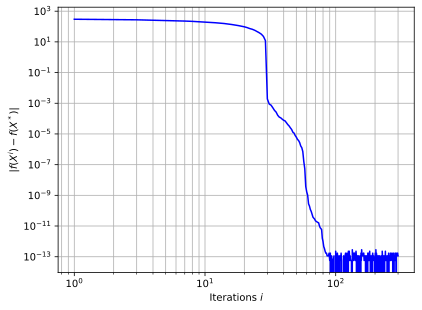

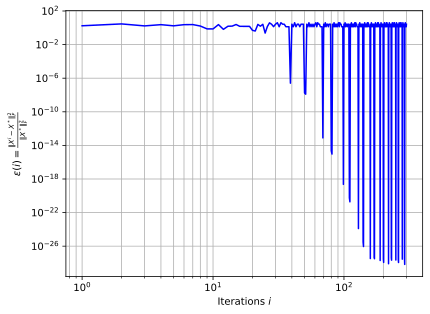

In [9]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt

dasf_solver_ambiguous.plot_objective_error()
dasf_solver_ambiguous.plot_error()
plt.show()

Let us now create a new PCA problem class, where this time we provide a method to resolve the ambiguity of the solutions. In particular, we select the sign of each column such that the resulting matrix is closest to the one from the previous iteration.

In [10]:
class PCAProblem(PCAProblemAmbiguous):
    def __init__(self, nb_filters:int) -> None:
        super().__init__(nb_filters=nb_filters)

    def resolve_ambiguity(self, X_reference, X_current, updating_node = None) -> np.ndarray:
        """Resolve the sign ambiguity for the GEVD problem."""

        for col in range(self.nb_filters):
            if np.linalg.norm(X_reference[:, col] - X_current[:, col]) > np.linalg.norm(
                -X_reference[:, col] - X_current[:, col]
            ):
                X_current[:, col] = -X_current[:, col]

        return X_current

We now run the DASF algorithm on the exact same problem, but with the new solver.

In [11]:
pca_problem=PCAProblem(nb_filters=nb_filters)
dasf_solver = DASF(
    problem=pca_problem,
    data_retriever=pca_data_retriever,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
    dynamic_plot=False,
)
dasf_solver.run()

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


As shown below, we see that adding a method to resolve the ambiguity of the solution makes the DASF algorithm converge both in objective and in iterates.

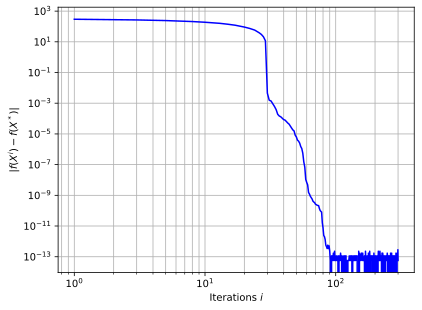

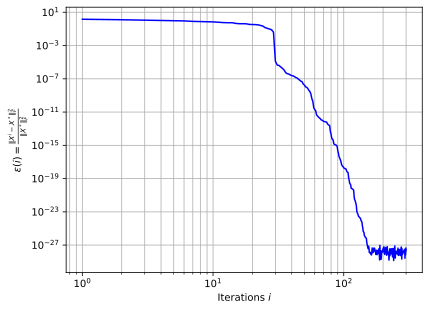

In [12]:
dasf_solver.plot_objective_error()
dasf_solver.plot_error()
plt.show()